In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import math
from tqdm import tqdm

from PIL import Image, ImageOps

In [2]:
DATA_DIR = "/root/autodl-tmp/cervical_spine/"
IMAGES_DIR = os.path.join(DATA_DIR, f"train_axial_images_jpeg95")
LABEL_DIR = os.path.join(DATA_DIR, f"segmentation_axial_labels")
XRAY_DIR = os.path.join(DATA_DIR, f"segmentation_sagittal_xray_labels")


In [3]:
label_dir_paths = glob.glob(os.path.join(DATA_DIR, 'segmentation_axial_labels') + '/**')
UIDs = [path.split("/")[-1] for path in label_dir_paths]
len(UIDs)

87

In [4]:
xray_df = pd.read_csv(os.path.join(DATA_DIR, 'meta_xray.csv')).drop_duplicates(subset='UID').set_index('UID')
xray_df = xray_df.loc[UIDs, "aspect"]
xray_df.head()

UID
1.2.826.0.1.3680043.10633    1.753425
1.2.826.0.1.3680043.10921    1.882354
1.2.826.0.1.3680043.11827    1.954198
1.2.826.0.1.3680043.11988    3.436242
1.2.826.0.1.3680043.12281    2.666667
Name: aspect, dtype: float64

In [5]:
sagittal_df = pd.read_csv(os.path.join(DATA_DIR, 'infer_sagittal_boundary.csv')).set_index('UID')
sagittal_df = sagittal_df.loc[UIDs, ['xmin','xmax']]
sagittal_df = sagittal_df.add_prefix('sagittal_')
sagittal_df.tail()

,sagittal_xmin,sagittal_xmax
UID,,
1.2.826.0.1.3680043.8330,69.323685,429.2296
1.2.826.0.1.3680043.8574,138.137010,389.4227
1.2.826.0.1.3680043.8744,-10.118713,418.2018
1.2.826.0.1.3680043.8884,107.355160,516.0630
1.2.826.0.1.3680043.9926,81.474365,330.1370


In [6]:
coronal_df = pd.read_csv(os.path.join(DATA_DIR, 'infer_coronal_boundary.csv')).set_index('UID')
coronal_df = coronal_df.loc[UIDs, ['xmin','xmax']]
coronal_df = coronal_df.add_prefix('coronal_')
coronal_df.tail()

,coronal_xmin,coronal_xmax
UID,,
1.2.826.0.1.3680043.8330,33.396835,456.48120
1.2.826.0.1.3680043.8574,155.723130,406.00723
1.2.826.0.1.3680043.8744,102.626400,436.05896
1.2.826.0.1.3680043.8884,98.245560,393.78183
1.2.826.0.1.3680043.9926,103.523580,379.67520


In [7]:
boundary_df = pd.concat((sagittal_df, coronal_df, xray_df), axis=1)
boundary_df.tail()

,sagittal_xmin,sagittal_xmax,coronal_xmin,coronal_xmax,aspect
UID,,,,,
1.2.826.0.1.3680043.8330,69.323685,429.2296,33.396835,456.48120,2.370369
1.2.826.0.1.3680043.8574,138.137010,389.4227,155.723130,406.00723,2.723404
1.2.826.0.1.3680043.8744,-10.118713,418.2018,102.626400,436.05896,3.938462
1.2.826.0.1.3680043.8884,107.355160,516.0630,98.245560,393.78183,2.254088
1.2.826.0.1.3680043.9926,81.474365,330.1370,103.523580,379.67520,2.844444


In [8]:
boundary_df["xmin"] = boundary_df["coronal_xmin"].clip(lower=0)
boundary_df["ymin"] = boundary_df["sagittal_xmin"].clip(lower=0)
boundary_df["xmax"] = boundary_df["coronal_xmax"].clip(upper=512)
boundary_df["ymax"] = boundary_df["sagittal_xmax"].clip(upper=512)
print(len(boundary_df))
boundary_df.tail()

87


,sagittal_xmin,sagittal_xmax,coronal_xmin,coronal_xmax,aspect,xmin,ymin,xmax,ymax
UID,,,,,,,,,
1.2.826.0.1.3680043.8330,69.323685,429.2296,33.396835,456.48120,2.370369,33.396835,69.323685,456.48120,429.2296
1.2.826.0.1.3680043.8574,138.137010,389.4227,155.723130,406.00723,2.723404,155.723130,138.137010,406.00723,389.4227
1.2.826.0.1.3680043.8744,-10.118713,418.2018,102.626400,436.05896,3.938462,102.626400,0.000000,436.05896,418.2018
1.2.826.0.1.3680043.8884,107.355160,516.0630,98.245560,393.78183,2.254088,98.245560,107.355160,393.78183,512.0000
1.2.826.0.1.3680043.9926,81.474365,330.1370,103.523580,379.67520,2.844444,103.523580,81.474365,379.67520,330.1370


1.2.826.0.1.3680043.15206


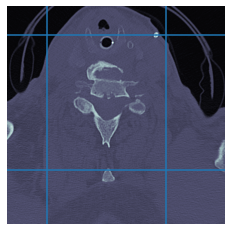

In [9]:
s = boundary_df.iloc[10]
print(s.name)
img = Image.open(os.path.join(IMAGES_DIR, s.name, '247.jpeg'))
plt.axis('off')
plt.imshow(img, cmap='bone')
plt.axvline(s.xmin)
plt.axvline(s.xmax)
plt.axhline(s.ymin)
plt.axhline(s.ymax)

In [10]:
train_df = pd.read_csv(os.path.join(DATA_DIR, 'train_df_with_slices.csv')).set_index('StudyInstanceUID')
train_df.head()

,patient_overall,C1,C2,C3,C4,C5,C6,C7,num_slices
StudyInstanceUID,,,,,,,,,
1.2.826.0.1.3680043.6200,1,1,1,0,0,0,0,0,243
1.2.826.0.1.3680043.27262,1,0,1,0,0,0,0,0,406
1.2.826.0.1.3680043.21561,1,0,1,0,0,0,0,0,385
1.2.826.0.1.3680043.12351,0,0,0,0,0,0,0,0,501
1.2.826.0.1.3680043.1363,1,0,0,0,0,1,0,0,199


In [11]:
df = pd.DataFrame()
for i in tqdm(range(len(boundary_df))):
    s = boundary_df.iloc[i]
    UID = s.name
    num_slices = train_df.loc[UID, 'num_slices']
    new_df = boundary_df.loc[[UID] * num_slices, ['xmin','ymin','xmax','ymax', 'aspect']]
    new_df['axial_index'] = np.arange(num_slices)
    df = pd.concat([df, new_df])

print(len(df))
df.tail()

100%|██████████| 87/87 [00:00<00:00, 576.25it/s]

29832


,xmin,ymin,xmax,ymax,aspect,axial_index
UID,,,,,,
1.2.826.0.1.3680043.9926,103.52358,81.474365,379.6752,330.137,2.844444,165
1.2.826.0.1.3680043.9926,103.52358,81.474365,379.6752,330.137,2.844444,166
1.2.826.0.1.3680043.9926,103.52358,81.474365,379.6752,330.137,2.844444,167
1.2.826.0.1.3680043.9926,103.52358,81.474365,379.6752,330.137,2.844444,168
1.2.826.0.1.3680043.9926,103.52358,81.474365,379.6752,330.137,2.844444,169


In [12]:
df.to_csv(os.path.join(DATA_DIR, 'segmentation_axial_bbox.csv'))